# Library imports

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import pandas as pd
import nibabel as nib

import torch
from torch.utils.data import DataLoader, Dataset, random_split

import sklearn
import sklearn.metrics

# Data analysis

In [5]:
dataset_dir = Path(os.getcwd()) / "Datasets" / "ADNI" / "ADNI1"
print(dataset_dir)

imgs_dir = dataset_dir / "Images"
masks_dir = dataset_dir / "SegmentationMasks"
store_dir = dataset_dir / "InputImages"
input_dir = store_dir

print(imgs_dir)
print(masks_dir)

csv_files = dataset_dir.glob("**/*.csv")
for csv_file in csv_files:
    csv_data = csv_file
    
print(csv_data)
df = pd.read_csv(csv_data)

d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1
d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1\Images
d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1\SegmentationMasks
d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1\ADNI1_T1_Imgs_CN-MCI-AD_5_18_2024.csv


In [3]:
df.head(7)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I118692,002_S_0295,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,11/02/2006,NiFTI,5/17/2024
1,I64025,002_S_0295,CN,M,86,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/25/2007,NiFTI,5/18/2024
2,I118671,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,4/18/2006,NiFTI,5/18/2024
3,I123685,002_S_0295,CN,M,87,m24,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/23/2008,NiFTI,5/17/2024
4,I150177,002_S_0295,CN,M,88,m36,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/22/2009,NiFTI,5/17/2024
5,I40966,002_S_0295,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,11/02/2006,NiFTI,5/17/2024
6,I45108,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,5/18/2024


In [7]:
def convert_date(acq_date):
    parsed_date = datetime.strptime(acq_date, f"%m/%d/%Y")
    return parsed_date.strftime(f"%Y-%m-%d")

def read_img(parent_dir, subject, date):
    input_img_path = parent_dir / f"{subject}__{date}.nii"
    if not os.path.exists(input_img_path):
        return None
    input_img = nib.load(input_img_path).get_fdata()
    return input_img
    # print(input_img.shape)
    # plot_axes(input_img, 130)    

def plot_16_coronal_slices(img, slice_number):
    slices = []
    for slice_no in range(slice_number - 7, slice_number + 9):
        slices.append(img[:, slice_no, :])# coronal

    # print(f"coronal shape = {slice2.shape}")
    plt.figure()

    fig, axes = plt.subplots(4, 4)

    plt.xticks([])  # Hide x axis ticks and labels
    plt.yticks([])  # Hide y axis ticks and labels

    # for ax in axes:
        # ax.set_xticks([])
        # ax.set_yticks([])

    for i in range(4):
        for j in range(4):
            axes[i][j].imshow(slices[i * 4 + j].T, cmap='gray', origin='lower')
            # axes[i][j].set_title(f"slice {i * 4 + j + 1}")
    plt.tight_layout
    plt.show()

def read_image(path):
    input_img = nib.load(path).get_fdata()
    return input_img

def separate_16_coronal_slices(img, slice_number):
    slices = []
    for slice_no in range(slice_number - 14, slice_number + 16):
        slices.append(img[:, slice_no, :]) # coronal
    return slices


# Preparing Dataset for Model

In [152]:
count = 0
img_paths = []
labels = []
additional_data = [] # (sex, age)

limit = 300
cn_limit = 0
mci_limit = 0
ad_limit = 0

input_shapes = {
    (256, 256, 166) : 128,
    # (192, 192, 160) : {86},
    # (240, 256, 160) : {128}
}

i = 0
for index, row in df.iterrows():
    group = row["Group"]
    # print(group)
    # print(count)
    
    subject = row["Subject"]
    date = convert_date(row["Acq Date"])
    input_img = read_img(input_dir, subject, date)
    
    # if image doesn't exist or doesn't follow shape criteria don't add it
    if input_img is None or input_img.shape not in input_shapes.keys():
        continue

    # if i == 1:
    #     plot_axes(input_img, input_shapes[input_img.shape])
    #     plot_16_coronal_slices(input_img, input_shapes[input_img.shape])
    # i = i + 1
    if group == "MCI":
        continue
    
    if group == "CN":
        if cn_limit == limit:
            continue
        cn_limit = cn_limit + 1
    else:
        if ad_limit == limit:
            continue
        ad_limit = ad_limit + 1 

    sex = 0 if row["Sex"] == 'M' else 1
    age = row["Age"]
    additional_data.append((sex, age))
    # print(additional_data)

    input_img_path = input_dir / f"{subject}__{date}.nii"
    img_paths.append(input_img_path)
    labels.append(row["Group"])


num_cn = 300
num_mci = 187
num_ad = 187

upsample_count = num_cn - num_ad
already_inserted = []

for idx, data in enumerate(img_paths):
    group = labels[idx]
    if group == 'AD' and upsample_count > 0:
        upsample_count = upsample_count - 1
        if idx not in already_inserted:
            already_inserted.append(idx)
            img_paths.append(img_paths[idx])
            labels.append(labels[idx])
            count = count + 1
            additional_data.append(additional_data[idx])

print(len(additional_data))
print(count)
print(len(labels))
#print(labels[:10])
#print(img_paths[:5])

print(len(labels))

600
113
600
600


# Dataset

In [153]:
def read_image(path):
    input_img = nib.load(path).get_fdata()
    return input_img

def min_max_normalize(image, new_min=0, new_max=1):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
    return normalized_image

def separate_coronal_slices_around(img, slice_number, slices_count):
    slices = []
    for slice_no in range(slice_number - slices_count, slice_number + slices_count + 1):
        slice = np.rot90(img[:, slice_no, :], k=2)
        slice = min_max_normalize(slice)
        slices.append(slice) # coronal
    return slices

class ADNI1_Dataset(Dataset):
    def __init__(self, img_paths, additional_data, labels, label_dict, input_shapes):
        self.img_paths = img_paths
        self.additional_data = additional_data
        self.labels = labels
        self.label_dict = label_dict
        self.input_shapes = input_shapes

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = read_image(self.img_paths[idx])
        coronal_slices = separate_coronal_slices_around(img, self.input_shapes[img.shape], 0)
        coronal_slices = torch.tensor(coronal_slices, dtype=torch.float)
        return coronal_slices, torch.tensor(self.additional_data[idx]), self.label_dict[self.labels[idx]]

label_dict = {
    "CN": 0,
    "AD": 1,
}

dataset = ADNI1_Dataset(img_paths, additional_data, labels, label_dict, input_shapes)

train_size = int(0.7 * len(dataset))
dev_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - dev_size

train_data, dev_data, test_data = random_split(dataset, [train_size, dev_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Model
From models/Resnet module

In [53]:
import importlib
import models.ResNet as RN
_ = importlib.reload(RN)

In [148]:
num_classes = len(label_dict.keys())
save_path = "model_resnet.pth"

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RN.ResNet101(device, num_classes)

model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
model.fc2 = torch.nn.Linear(in_features=model.fc2.in_features, out_features=2, bias=True)

# if os.path.exists(save_path):
#     print(f"found saved state at: {save_path}")
#     checkpoint = torch.load(save_path)
#     model.load_state_dict(checkpoint['model_state_dict'])  

model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

In [160]:
num_classes = len(label_dict.keys())
save_path = "weights/model_resnet.pth"

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RN.ResNet18(device, num_classes)

model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
model.fc2 = torch.nn.Linear(in_features=model.fc2.in_features, out_features=2, bias=True)

# if os.path.exists(save_path):
#     print(f"found saved state at: {save_path}")
#     checkpoint = torch.load(save_path)
#     model.load_state_dict(checkpoint['model_state_dict'])  

model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

# Hyperparameters for training loop

In [161]:
num_epochs = 100
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
dev_losses = []

In [165]:
prev_best_eval_acc = 0.7
version = 7
iter = 5

for epoch in range(num_epochs):
    print(f"epoch = {epoch + 1}/{num_epochs}")
    train_running_loss = 0
    n = 0
    # don't put (data, labels) here instead of data. it botches the self.labels in the loader for some reason
    acc = 0
    conf_matrix = np.zeros((2, 2))
    for batch_idx, data in enumerate(train_loader):
        n = n + 1
        if batch_idx % 10 == 0:
            print(f"batch id = {batch_idx}")    
            pass
        imgs, additional_data, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        outputs = model(imgs, additional_data)

        optimizer.zero_grad() # cleans gradients
        loss = criterion(outputs, labels)
        loss.backward() # computes gradients
        optimizer.step() # applies gradient modifications

        train_running_loss += loss.item()
        acc = acc + torch.sum(torch.argmax(outputs, dim=1) == labels) / len(labels)
        preds = torch.argmax(outputs, dim=1)
        conf_matrix += sklearn.metrics.confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy(), labels=np.arange(2))
    
    print(conf_matrix)
    train_losses.append(train_running_loss / n)
    print(f"train loss = {train_running_loss / n}, acc = {acc / n}")


    dev_running_loss = 0
    conf_matrix = np.zeros((2, 2))
    n = 0
    acc = 0
    for i, data in enumerate(dev_loader):
        # if i % 10 == 0:
        #     print(f"batch_id = {i}")
        n = n + 1
        imgs, additional_data, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        
        outputs = model(imgs, additional_data)
        loss = criterion(outputs, labels)
        dev_running_loss += loss.item()    
        # loss.backward()

        acc = acc + torch.sum(torch.argmax(outputs, dim=1) == labels) / len(labels)
        conf_matrix += sklearn.metrics.confusion_matrix(labels.cpu().numpy(), torch.argmax(outputs, dim=1).cpu().numpy(), labels=np.arange(2))
        
    print(conf_matrix)
    print(f"dev loss = {dev_running_loss / n}, accuracy = {acc / n}")
    dev_losses.append(dev_running_loss / n)
    if acc / n > prev_best_eval_acc:
        print(f"new best acc: {acc / n}")
        version = version + 1
        prev_best_eval_acc = acc / n
        dt_save_path = f"weights/model_resnet_{iter}_{version}.pth"
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss
        }, dt_save_path)
    print()

epoch = 1/100
batch id = 0
batch id = 10
[[206.   9.]
 [ 19. 186.]]
train loss = 0.17628375653709685, acc = 0.9218750596046448
[[33. 11.]
 [ 6. 40.]]
dev loss = 0.47470871607462567, accuracy = 0.8133012652397156
new best acc: 0.8133012652397156

epoch = 2/100
batch id = 0
batch id = 10
[[200.  15.]
 [ 13. 192.]]
train loss = 0.2297774345747062, acc = 0.9375000596046448
[[41.  3.]
 [12. 34.]]
dev loss = 0.45753683646519977, accuracy = 0.834134578704834
new best acc: 0.834134578704834

epoch = 3/100
batch id = 0
batch id = 10
[[196.  19.]
 [ 23. 182.]]
train loss = 0.30608523956366945, acc = 0.8750000596046448
[[34. 10.]
 [10. 36.]]
dev loss = 0.6001102228959402, accuracy = 0.7820512652397156

epoch = 4/100
batch id = 0
batch id = 10
[[205.  10.]
 [ 28. 177.]]
train loss = 0.23827754812581198, acc = 0.8995535969734192
[[33. 11.]
 [ 8. 38.]]
dev loss = 0.4656151831150055, accuracy = 0.7852563858032227

epoch = 5/100
batch id = 0
batch id = 10
[[204.  11.]
 [ 17. 188.]]
train loss = 0.1997

KeyboardInterrupt: 

# Save

In [177]:
pt_save_path = 'model_resnet_best.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss
}, pt_save_path)

# Testing

## Load model

In [190]:
num_classes = len(label_dict.keys())
# save_path = "model_resnet_17.pth"
save_path = "model_resnet_best.pth"

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RN.ResNet18(device, num_classes)

model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
model.fc2 = torch.nn.Linear(in_features=model.fc2.in_features, out_features=2, bias=True)

if os.path.exists(save_path):
    print(f"found saved state at: {save_path}")
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])  
_ = model.to(device)

found saved state at: model_resnet_best.pth


In [76]:
test_losses = []

In [210]:
idx = 20
print(test_data.dataset.img_paths[idx])
print(test_data.dataset.additional_data[idx])
print(test_data.dataset.labels[idx])

d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1\InputImages\002_S_0816__2006-08-30.nii
(0, 71)
AD


In [191]:
test_running_loss = 0
conf_matrix = np.zeros((2, 2))
criterion = torch.nn.CrossEntropyLoss()
n = 0
acc = 0
sens = 0
spec = 0
auc = 0
for i, data in enumerate(test_loader):
    if i % 10 == 0:
        print(f"batch_id = {i}")
    n = n + 1
    imgs, additional_data, labels = data[0].to(device), data[1].to(device), data[2].to(device)
    
    outputs = model(imgs, additional_data)
    loss = criterion(outputs, labels)
    loss.backward()
    test_running_loss += loss.item()    
    
    conf_matrix += sklearn.metrics.confusion_matrix(labels.cpu().numpy(), torch.argmax(outputs, dim=1).cpu().numpy(), labels=np.arange(2))

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    sens = sens + TP / (TP + FN)  # True Positive Rate (TPR)
    spec = spec + TN / (TN + FP)  # True Negative Rate (TNR)
    auc = auc + sklearn.metrics.roc_auc_score(labels.cpu().numpy(), torch.argmax(outputs, dim=1).cpu().numpy())
    acc = acc + torch.sum(torch.argmax(outputs, dim=1) == labels) / len(labels)

print(conf_matrix)
print(f"eval loss = {test_running_loss / n}, accuracy = {acc / n}")
print(f"sensitivity = {sens / n}, specificity = {spec / n}, AUC = {auc / n}")
test_losses.append(test_running_loss / n)

batch_id = 0
[[36.  5.]
 [ 4. 45.]]
eval loss = 0.734869917233785, accuracy = 0.8942307829856873
sensitivity = 0.95427059712774, specificity = 0.8910956252419667, AUC = 0.896131354026091


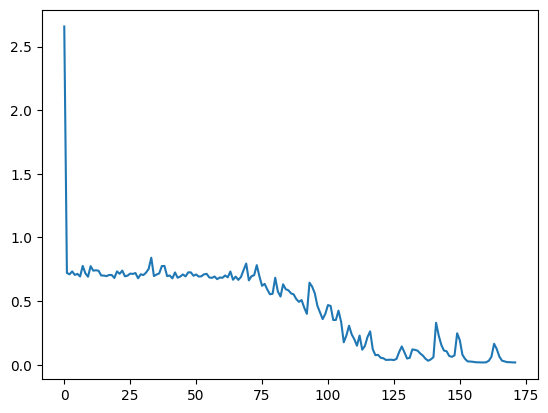

In [172]:
plt.plot(train_losses)
with open("text_2.txt", 'w') as file:
    for loss in train_losses:
        file.write(str(loss) + "\n")
# _ = plt.yticks(list(range(0,3)))

# Loss plotting

Text(0, 0.5, 'loss')

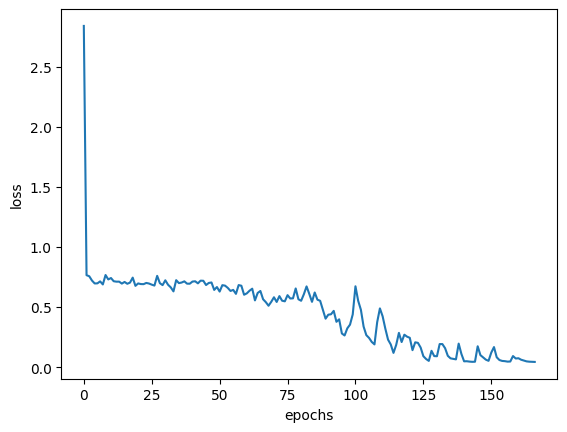

In [146]:
_train_losses = []
with open("text.txt", 'r') as file:
    for line in file:
        _train_losses.append(float(line.strip()))
plt.plot(_train_losses)
plt.xlabel('epochs')
plt.ylabel('loss')